In [1]:
from fastai.vision.all import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Creating a Fast AI Street Modell with the osmx street masks

In [2]:
# function to get the masks with the streets(masks from osmx)
def mask_function(name):
    return np.load(str(name).replace("img.png", "street_mask.npy"))

In [3]:
#function to get the images
def get_images(name):
    return get_image_files(name)

In [10]:
path = Path("/kaggle/input/tds-masks/train_test_split")
train_path = path/"train"
test_path = path/"test"

In [12]:
#create a Datablock with the masks and images
satellite_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ["background","street"])),
                 get_items=get_images,
                 splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                 get_y=mask_function,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=256, max_lighting=0.3)
)

In [13]:
#create the dataloader based on the Datablock
dataloader = satellite_block.dataloaders(path, bs=4)

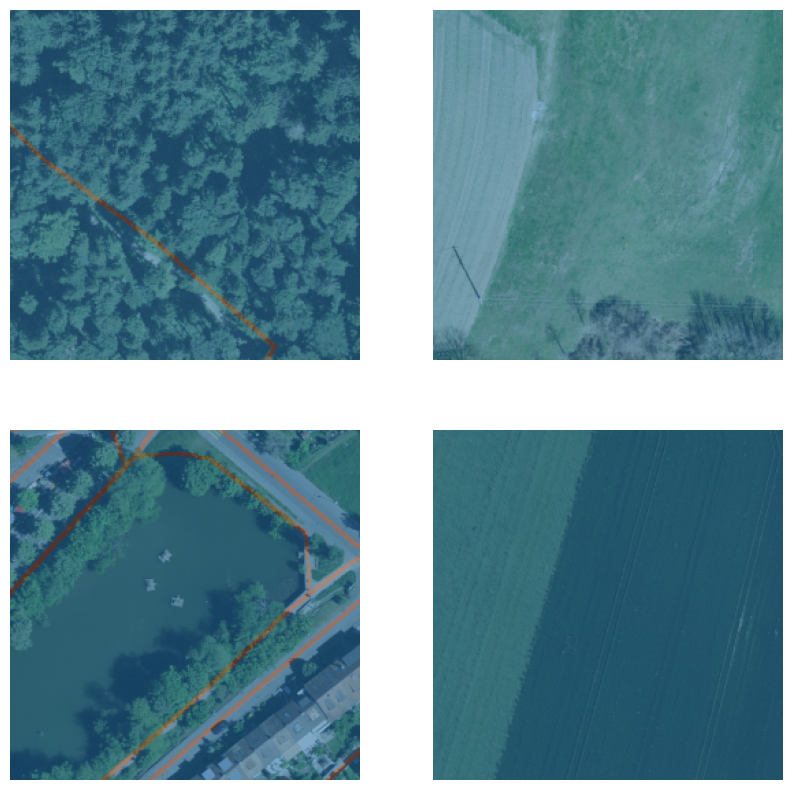

In [14]:
dataloader.show_batch(max_n=4, figsize=(10,10))

### create a learner and train it in a frozen state

In [15]:
learner = unet_learner(dataloader,resnet50,metrics=Dice)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s] 


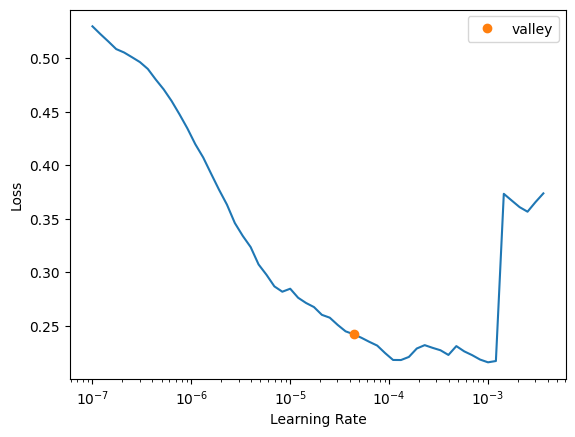

In [16]:
lr = learner.lr_find()

In [17]:
learner.fit_one_cycle(20, lr_max=lr.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=5, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_model')])

epoch,train_loss,valid_loss,dice,time
0,0.085876,0.083093,0.001523,05:16
1,0.095779,0.080287,0.000000,05:15
2,0.075999,0.075152,0.016671,05:15
3,0.079082,0.075483,0.046455,05:15
4,0.079513,0.074209,0.096494,05:15
5,0.069634,0.068965,0.106112,05:15
6,0.080190,0.080651,0.024773,05:15
7,0.072337,0.066941,0.115573,05:15
8,0.059710,0.066686,0.156625,05:15
9,0.076002,0.082303,0.097312,05:15


Better model found at epoch 0 with dice value: 0.001523431031627753.
Better model found at epoch 2 with dice value: 0.016671112054622024.
Better model found at epoch 3 with dice value: 0.04645544791545616.
Better model found at epoch 4 with dice value: 0.09649366488244461.
Better model found at epoch 7 with dice value: 0.11557256786847728.
Better model found at epoch 8 with dice value: 0.15662469369434942.
Better model found at epoch 10 with dice value: 0.2474575828272695.
Better model found at epoch 11 with dice value: 0.29821919094207777.
Better model found at epoch 16 with dice value: 0.32054202904293044.


### create an unfrozen learner and train it

In [18]:
learner = learner.load('best_frozen_model')
learner.unfreeze()

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


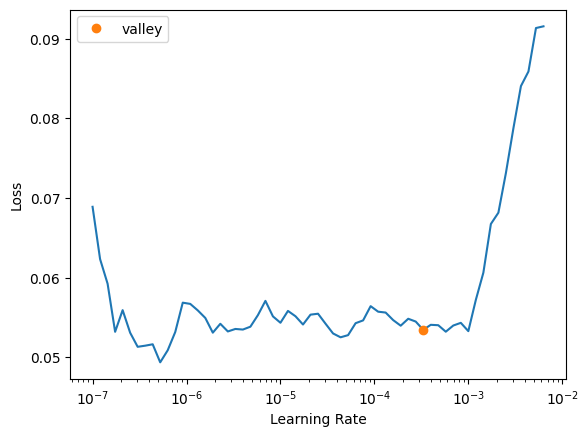

In [19]:
lr = learner.lr_find()

In [20]:
learner.fit_one_cycle(
    20, lr_max=slice(lr.valley/10,lr.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=5, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_model')]
         )

epoch,train_loss,valid_loss,dice,time
0,0.068619,0.070672,0.028407,05:20
1,0.087124,0.074471,0.000000,05:17
2,0.069196,0.080518,0.000000,05:16
3,0.487047,0.083876,0.003193,05:17
4,0.071907,0.077214,0.057144,05:16
5,0.069401,0.068897,0.156819,05:15
6,0.072289,0.068572,0.018994,05:15
7,0.063789,0.068178,0.011525,05:15
8,0.065456,0.066544,0.213464,05:15
9,0.070967,0.066481,0.050393,05:15


Better model found at epoch 0 with dice value: 0.028407117079009656.
Better model found at epoch 4 with dice value: 0.05714430157900945.
Better model found at epoch 5 with dice value: 0.15681851351265602.
Better model found at epoch 8 with dice value: 0.21346445141514497.
Better model found at epoch 12 with dice value: 0.2768191862446543.
Better model found at epoch 14 with dice value: 0.3144807643420049.
Better model found at epoch 17 with dice value: 0.32177306706169084.
Better model found at epoch 19 with dice value: 0.32357129622276926.
No improvement since epoch 14: early stopping


### check the performance via the dice score

In [21]:
learner = learner.load("best_model")

In [22]:
print("in-sample performance: {}".format(np.array(learner.validate(ds_idx=0)[1]))) # Dice Score

in-sample performance: 0.3717167456329986


In [23]:
print("out-of-sample performance: {}".format(np.array(learner.validate(ds_idx=1)[1]))) # Dice Score

out-of-sample performance: 0.32357129622276926


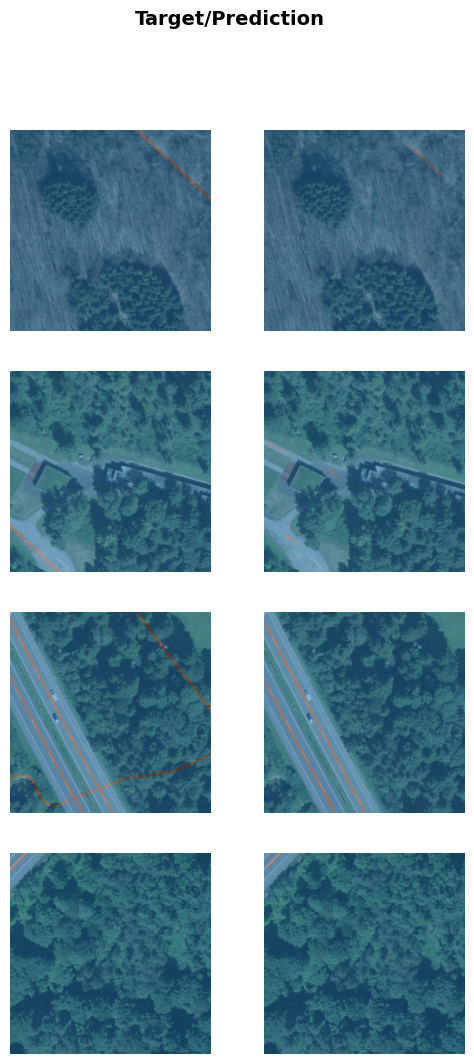

In [26]:
#show the predictions
learner.show_results(max_n=4)